In [133]:
from matplotlib import pyplot as plt
from pylab import *
import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
import cmath
sys.path.insert(0, '/Users/haly/idefix/pytools')
from vtk_io import *
pi = 3.14






In [653]:
# Some useful functions

def calculate_KE(directory,snapshot,Nx,Nz):
    file    = directory + "/data."+ "{:04d}".format(snapshot) + ".vtk"
    d = readVTK(file, geometry='cartesian')
    rho_g = d.data.get("RHO")
    vz_g = d.data.get("VX3")
    rho_g = rho_g.reshape(Nx,Nz)
    vz_g = vz_g.reshape(Nx,Nz)

    return (0.5*1.2/Nz*1/Nx*pi*np.sum(rho_g*vz_g*vz_g))

def calculate_growth_rate(kx,n,w,psi,ts,f):
    Lz = 1
    kb = 2.*pi/Lz
    C1 = (kx*(2*w+1)*((w+1)**2*w**2-kb**2*(n+1)*(n+w**2)))/(8*w*(w**2-n*kb)*(w**2+n*kb))
    C2 = (-kx*(2*w+1)*(w**2*(1+w)**2+n*kb**2*w*(2+w)-n**2*kb**2))/(8*(1+w)*((1+w)**2-(n+1)*kb)*((1+w)**2+(n+1)*kb))
    D1 = ((w**2-1)*(-n**2*ts*kb**2*(1j+2*ts*w)+(1j+ts*w)*w**2*(ts+1j*w+ts*w**2)))/(2*(1j+ts*(w-1))*(1j+ts*w)*(1j+ts+ts*w)*(w**4-n**2*kb**2))
    D2 = (-w*(2+w)*((1+w)**3-ts**2*(1+w)*(-2*(1+n)**2*kb**2+(1+w)**2*(2+w*(2+w)))+1j*ts*((1+n)**2*kb**2-(1+w)**2*(3+2*w*(2+w)))))/(2*(1j+ts*w)*(1j+ts+ts*w)*((1+w)**2-(1+n)*kb)*((1+w)**2+(1+n)*kb)*(1j+ts*(2+w)))
    S1 = (-f*(D1+D2)+cmath.sqrt(f**2*(D1**2+D2**2-2*D1*D2)+4*psi**2*C1*C2))/2
    S2 = (-f*(D1+D2)-cmath.sqrt(f**2*(D1**2+D2**2-2*D1*D2)+4*psi**2*C1*C2))/2
    return max(np.real(S1), np.real(S2))

def calculate_dust_eigenmodes(kx,n,w,ts):
    Lz = 1
    kb = 2.*pi/Lz
    pert=0.0001

    ug = 1j*w*(w**2-kb**2*n**2)
    vg = 0.5*(w**2-kb**2*n**2)
    wg = 1j*kx*kb*n*w
    chi = -(1j+ts*(w+1))/(1j+ts*(w-1))

    ud = (ug+2*ts*vg-1j*ts*ug*w)/chi
    vd = (-2*vg+ts*(ug+2j*vg*w))/(-2*chi)
    wd = (1j*wg)/(1j+ts*w)
    hd = (1j/w)*((kb*n*wg)/(1j+ts*w)-(kx*(1j*(ug+2*ts*vg)+ts*ug*w))/(chi))
    tex1 = f'cos(Kx*x+Kb*{n}*z)'
    tex2 = f'sin(Kx*x+Kb*{n}*z)'
    norm_real = pert/np.real(ud)
    norm_imag = pert/np.imag(ud)

    print(f"rho_d *= exp({norm_real*np.real(hd):.8f}*{tex1}-{norm_imag*np.imag(hd):.8f}*{tex2});")
    print(f"ud += {norm_real*np.real(ud):.8f}*{tex1}-{norm_imag*np.imag(ud):.8f}*{tex2};")
    print(f"vd += {norm_real*np.real(vd):.8f}*{tex1}-{norm_imag*np.imag(vd):.8f}*{tex2};")
    print(f"wd += {norm_real*np.real(wd):.8f}*{tex1}-{norm_imag*np.imag(wd):.8f}*{tex2};")



In [654]:
calculate_dust_eigenmodes(kx=15.6,n=1,w=-0.373,ts=1)

rho_d *= exp(-0.00339275*cos(Kx*x+Kb*1*z)--0.00332234*sin(Kx*x+Kb*1*z));
ud += 0.00010000*cos(Kx*x+Kb*1*z)-0.00010000*sin(Kx*x+Kb*1*z);
vd += -0.00007479*cos(Kx*x+Kb*1*z)-0.00004725*sin(Kx*x+Kb*1*z);
wd += -0.00004690*cos(Kx*x+Kb*1*z)--0.00005108*sin(Kx*x+Kb*1*z);


In [659]:
print(calculate_growth_rate(kx=15.6,n=1,w=-0.373,psi=0.01,ts=1,f=0.04))


0.0008929346457673196


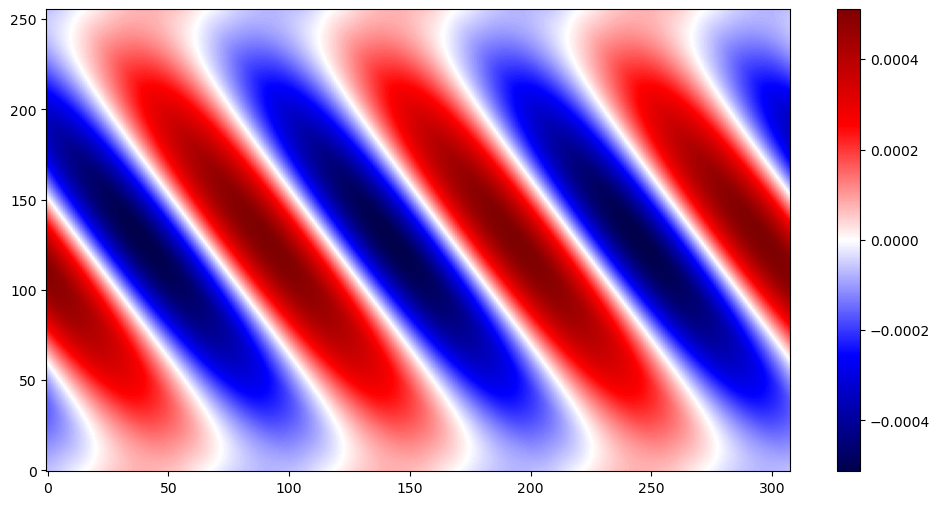

In [ ]:
# Read and plot gas

plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1,1)

#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test/run"
directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/gas/run_256"

snapshot = 5
Nx = 308
Nz= 256


file = directory + f"/data.{snapshot:04d}.vtk"
d = readVTK(file, geometry='cartesian')
rho_g = d.data.get("RHO")
vx_g = d.data.get("VX1")
vy_g = d.data.get("VX2")
vz_g = d.data.get("VX3")
rho_g = rho_g.reshape(Nx,Nz)
vx_g = vx_g.reshape(Nx,Nz)
vy_g = vy_g.reshape(Nx,Nz)
vz_g = vz_g.reshape(Nx,Nz)

im = axs.imshow(vz_g.T,origin='lower',norm="linear",cmap="seismic", aspect='auto')
fig.colorbar(im)


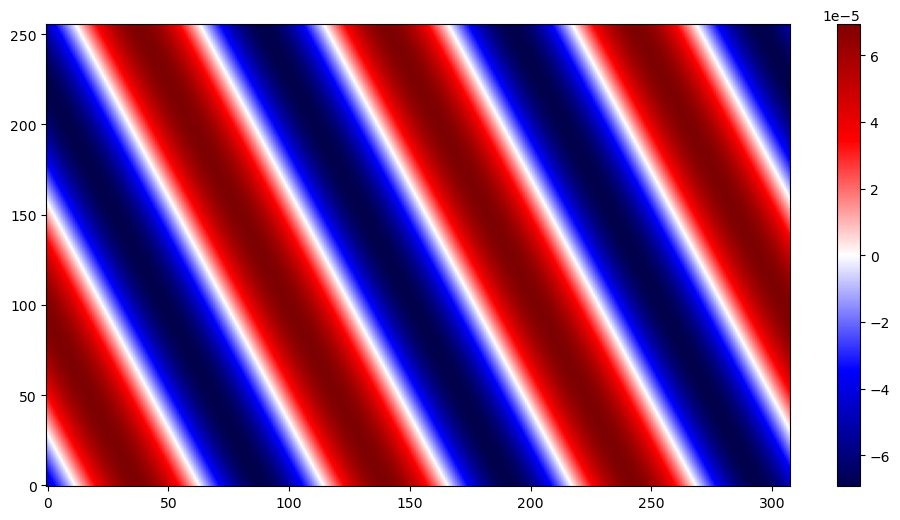

In [ ]:
# Read and plot dust

plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1,1)

directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.01/run"

snapshot = 0
Nx = 308
Nz= 256


file = directory + f"/data.{snapshot:04d}.vtk"
d = readVTK(file, geometry='cartesian')
rho_d = d.data.get("Dust0_RHO")
vx_d = d.data.get("Dust0_VX1")
vy_d = d.data.get("Dust0_VX2")
vz_d = d.data.get("Dust0_VX3")
rho_d = rho_d.reshape(Nx,Nz)
vx_d = vx_d.reshape(Nx,Nz)
vy_d = vy_d.reshape(Nx,Nz)
vz_d = vz_d.reshape(Nx,Nz)

im = axs.imshow(vz_d.T,origin='lower',norm="linear",cmap="seismic", aspect='auto')
fig.colorbar(im)

Text(0.5, 1.0, '$\\tau_s=1$, $f=0.05$')

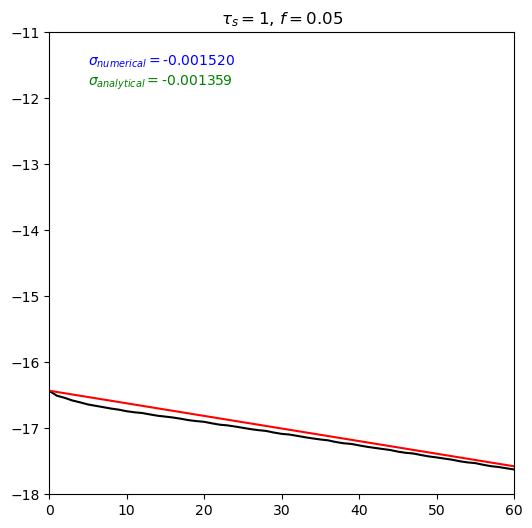

In [666]:
# calculate numerical and analytical growth rates

plt.rcParams["figure.figsize"] = (6,6)
fig, axs = plt.subplots(1,1)

#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/gas/run_256"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.05/run"
directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.05/run"

Nx = 308
Nz= 256
f = 0.05

time= linspace(0,60,num=61)
KE = zeros_like(time)
for i in range(0,len(KE)):
    KE[i]=calculate_KE(directory,i,Nx,Nz)
KE_for_fit = KE[0:31]
time_for_fit = time[0:31]


slope, intercept, r, p, se = sp.stats.linregress(time_for_fit, log(KE_for_fit))
axs.plot(time, log(KE),color='black')
axs.axline((time[0],log(KE[0])),slope=slope,color='red')
axs.set_xlim(0,60)
axs.set_ylim(-18,-11)
axs.text(5,-11.5,r'$\sigma_{numerical}=$'+"{:06f}".format(slope/2./pi/2.), color="blue")
axs.text(5,-11.8,r'$\sigma_{analytical}=$'+"{:06f}".format(calculate_growth_rate(kx=15.6,n=1,w=-0.373,psi=0.01,ts=1,f=f)), color="green")
axs.set_title(fr'$\tau_s=1$, $f={f}$')